🎯 What You'll Learn in This Video:

✅ How to generate a monthly NDVI time series for ROI using Lansat-8

✅How to Visualize NDVI time series using matplotlib and plotly express

✅ How to export the results to CSV after analysis



what is xarray?:

 هي مكتبة بايثون مخصصة للتعامل مع البيانات متعددة الأبعاد مثل بيانات الأقمار الصناعية، حيث تسمح بتنظيم البيانات عبر أبعاد مثل الزمن، خط العرض، وخط الطول بطريقة سهلة وقابلة للتحليل.
  تدعم بيانات ثلاثية أو رباعية الأبعاد، مما يجعلها مثالية للبيانات المناخية والزراعية والزمنية.

What is XEE?:

مكتبة بيثون تساعد في تحويل بيانات جوجل ايرث الي شكل مصفوفة بشكل مباشر

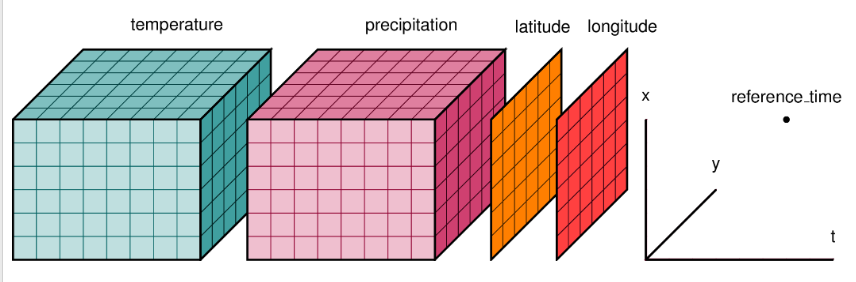

In [ ]:
!pip install xee

In [ ]:
import ee
import geemap
import pandas as pd
import xarray as xr
import xee
import matplotlib.pyplot as plt
import plotly.express as px


In [ ]:
# Authenticate to Earth Engine.
ee.Authenticate()

# Initialize Earth Engine with your project ID
ee.Initialize(project =  'ee-nouribrahim25' , opt_url = 'https://earthengine-highvolume.googleapis.com')

In [ ]:
# convert coordinates into geometry polygon
coors = [[30.441828, 28.117864],
    [30.442558, 28.112905],
    [30.463415, 28.115593],
    [30.462513, 28.120362],
    [30.441828, 28.117864]]

roi = ee.Geometry.Polygon(coors)
roi

In [ ]:
# See the ROI on the map
Map = geemap.Map(width = 800)
Map.centerObject(roi, 12)
Map.add_layer(roi, {} , 'ROI')
Map

In [ ]:
# Define start and end dates
start_date = '2016-01-01'
end_date = '2024-12-31'

In [ ]:
# Load Landsat-8 SR
landsat = (ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
          .filterBounds(roi)
          .filterDate(start_date, end_date)
          .filter(ee.Filter.lt('CLOUD_COVER', 20))
)

landsat.size()

In [ ]:
# Applies scaling factors.
def apply_scale(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  return image.addBands(optical_bands, None, True)

In [ ]:
# Cloud Masking
def mask_cloud(image):
  qa = image.select('QA_PIXEL')
  cloud = 1 << 3
  cloud_shadow = 1 << 4
  mask = qa.bitwiseAnd(cloud).eq(0).And(qa.bitwiseAnd(cloud_shadow).eq(0))
  return image.updateMask(mask)



In [ ]:
# NDVI calculation
def add_ndvi(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    return image.addBands(ndvi)

In [ ]:
# Applies all functions to landsat image collection
landsat_clean = landsat.map(apply_scale).map(mask_cloud).map(add_ndvi)
landsat_clean.first()

Convert to xarray Dataset via xee

In [ ]:
# converting the landsat_clean into xarray ds
ds = xr.open_dataset(
    landsat_clean,
    engine='ee',
    crs='EPSG:4326',
    scale=0.00030,       # 30m in degrees (~0.00025)
    geometry=roi,
    chunks={'time': 50}  # Dask chunks: process big data in smaller parts to save memory and speed up computation
)

In [ ]:
ds

In [ ]:
# Sort by time to ensure monotonic index
ds = ds.sortby('time')

In [ ]:
# Resample Monthly NDVI Mean
monthly = ds.resample(time='M').mean('time')


In [ ]:
monthly

Calculate the spatial mean NDVI , convert to pandas DataFrame and export to CSV

In [ ]:
# Calculate the spatial mean NDVI by averaging over longitude and latitude
mean_ndvi = monthly.NDVI.mean(dim=['lon', 'lat'])

# Convert time series to pandas DataFrame
ndvi_df = mean_ndvi.to_dataframe().reset_index()
ndvi_df.head()

# Export the DataFrame to a CSV file
ndvi_df.to_csv('ndvi_monthly.csv', index=False)

Plot with matplotlib

In [ ]:
# Plot NDVI time series
plt.figure(figsize=(15, 6))
plt.plot(ndvi_df['time'], ndvi_df['NDVI'], marker='o', linestyle='-')
plt.title('Mean NDVI Time Series for ROI (Monthly)')
plt.xlabel('Date')
plt.ylabel('Mean NDVI')
plt.grid(True)

plt.show()

plot interactive figure with plotly express

In [ ]:
fig = px.line(
    ndvi_df,
    x='time',
    y='NDVI',
    title='Mean NDVI Time Series for ROI (Monthly)',
    labels={'NDVI': 'Mean NDVI', 'time': 'Date'},
)
fig.show()


In [ ]:
# Calculate median NDVI for last year(2024)
median_img = (landsat_clean.select('NDVI').
            filterDate('2024-01-01', '2024-12-31')
            .mean().clip(roi))

# Add it to the map
Map.centerObject(roi, 14)
Map.addLayer(median_img, {'min': 0, 'max': 0.5, 'palette': ['white', 'green']}, 'Mean NDVI 2024')
Map